In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from datetime import datetime
import pytz #for timezone calculation
import math
import matplotlib.dates as md
import gc
import os
%matplotlib qt
%matplotlib inline

In [2]:
# ================== Global parameters for fonts & sizes =================
font_size = 10
rc={'font.size': font_size, 'axes.labelsize': font_size, 'legend.fontsize': font_size, 
    'axes.titlesize': font_size, 'xtick.labelsize': font_size, 'ytick.labelsize': font_size}
plt.rcParams.update(**rc)
plt.rc('font', weight='bold')
 
# For label titles
fontdict={'fontsize': font_size, 'fontweight' : 'bold'}
# can add in above dictionary: 'verticalalignment': 'baseline' 

style = 'ggplot' # choose a style from the above options
plt.style.use(style)

In [26]:
# VWATT CLASSES AND FUNCTIONS

# SITE AND CIRCUIT CLASSES USED TO ORGANISE THE SITES TELEMETRY AND META DATA FOR EASE IN PROCESSING

class Site:
  def __init__(self, site_id, s_postcode, pv_install_date, ac_cap_w, dc_cap_w, inverter_manufacturer, inverter_model):
    self.site_id = site_id
    self.s_postcode = s_postcode
    self.pv_install_date = pv_install_date
    self.ac_cap_w = ac_cap_w
    self.dc_cap_w = dc_cap_w
    self.inverter_manufacturer = inverter_manufacturer
    self.inverter_model = inverter_model
    self.c_id_data = {}

class Circuit:
  def __init__(self, c_id, site_id, con_type, polarity):
    self.c_id = c_id
    self.con_type = con_type
    self.polarity = polarity
    self.day_data = {}
    
# ADJUST FORMATE FOR TIMESTAMP STRINGS
def Get_timestamp_date_string(string):
    x = string.split("_")
    return x[0] + "-" + x[1]

# SEPARATE THE BoM GHI DATA FILES PER DAY TO SEARCH FOR CLEAR SKY DAYS
def Separate_ghi_data(month, ghi):
    ghi['ts'] = pd.to_datetime(pd.DataFrame({'year': ghi['Year Month Day Hours Minutes in YYYY'].values,
                                                    'month': ghi['MM'],
                                                    'day': ghi['DD'],
                                                    'hour': ghi['HH24'],
                                                    'minute': ghi['MI format in Local standard time']}))
    ghi.rename(columns={'Mean global irradiance (over 1 minute) in W/sq m': 'mean_ghi',
                        'Minimum 1 second global irradiance (over 1 minute) in W/sq m': 'min_ghi',
                        'Maximum 1 second global irradiance (over 1 minute) in W/sq m': 'max_ghi',
                        'Standard deviation of global irradiance (over 1 minute) in W/sq m': 'sd_ghi',
                        'Uncertainty in mean global irradiance (over 1 minute) in W/sq m': 'uncertainty_ghi'},
               inplace=True)
    key_ghi_values = ghi[['ts', 'mean_ghi', 'min_ghi', 'max_ghi', 'sd_ghi', 'uncertainty_ghi']].copy()
    key_ghi_values['mean_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['mean_ghi']), axis=1)
    key_ghi_values['min_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['min_ghi']), axis=1)
    key_ghi_values['max_ghi'] = key_ghi_values.apply(lambda row: String_to_Float(row['max_ghi']), axis=1)


    combined_ghi_dict = {}
    month_number = int(month.split('-')[1])

    for day in range(1, Days_in_month(month_number) + 1):
        day_string = str(day)
        if day < 10:
            day_string = "0" + day_string

        date = month + "-" + day_string
        df = key_ghi_values.loc[key_ghi_values['ts'] > date + " 00:00:01"]
        df = df.loc[key_ghi_values['ts'] < date + " 23:59:01"]

        combined_ghi_dict[date] = df

    return combined_ghi_dict

# REMOVE SPACES AND CHECK IF VALUE NULL
def String_to_Float(string):
    x = string.strip()
    if not x:
        x = 0
    else:
        x = float(x)
    return x

def Days_in_month(month):
        switcher = {
            1: 31,
            2: 29,
            3: 31,
            4: 30,
            5: 31,
            6: 30,
            7: 31,
            8: 31,
            9: 30,
            10: 31,
            11: 30,
            12: 31,
        }
        return switcher.get(month, 0)
    
# LOOK FOR FOR SUDDEN VARIATIONS IN SOLAR INSOLATION DATA WHICH INDICATES LIKELY CLOUD COVER, AS OPPOSED TO CLEAR PARABOLIC SHAPE OF CLEAR SKY DAY GHI CURVES
def Detect_clear_sky_day(ghi_df, min_max_ghi):
    df_daytime = ghi_df.loc[ghi_df['mean_ghi'] > 0]

    collective_change = 0
    ghi_list = df_daytime.mean_ghi.tolist()

    for i in range(len(ghi_list)-1):
        collective_change += abs(ghi_list[i+1] - ghi_list[i])

    if len(df_daytime.index) == 0:
        return False, 0
    
    average_delta_y = collective_change/len(df_daytime.index)

    if average_delta_y < 5 and max(ghi_df.mean_ghi) > min_max_ghi:
        return True, average_delta_y
    else:
        return False, average_delta_y
    
def Get_telemetry_string(string):
    x = string.split("_")
    return x[0] + x[1]

def Filter_data_clear_sky_days(data, clear_sky_days):
    filtered_df = None
    
    for day in clear_sky_days:
        tmp_df = data.loc[data['utc_tstamp'] > Convert_SA_time_to_UTC(day + " 00:00:01")]
        tmp_df = tmp_df.loc[tmp_df['utc_tstamp'] < Convert_SA_time_to_UTC(day + " 23:59:01")]

        if filtered_df is None:
            filtered_df = tmp_df
        else:
            filtered_df = filtered_df.append(tmp_df, ignore_index=True)

    return filtered_df

def Convert_SA_time_to_UTC(sa_time):
    timeFormat = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(sa_time, timeFormat)
    sa_local_time = pytz.timezone('Australia/Adelaide')
    utc_time = pytz.utc
    sa_moment = sa_local_time.localize(x, is_dst=None)
    utc_time = sa_moment.astimezone(utc_time)
    a = utc_time.strftime(timeFormat)
    return a

# ORGANISES ALL TELEMETRY IN THE HIERARCHY: SITE->CIRCUITS->DAYS_OF_DATA
def Organise_sites(clear_sky_days, site_id_list, month, inverter_telemetry, site_details, cicuit_details):  # add gen data

    overall_site_organiser = {}

    for site_id in site_id_list:
        if site_id not in site_details.site_id.unique():
            continue
        overall_site_organiser[site_id] = Organise_individual_site(clear_sky_days, site_id, month, inverter_telemetry,
                                        site_details.loc[site_details['site_id'] == site_id],
                                        cicuit_details.loc[
                                            cicuit_details['site_id'] == site_id])

    return overall_site_organiser


def Organise_individual_site(clear_sky_days, site_id, month, inverter_telemetry, site_details, cicuit_details):
    site = Site(site_id, site_details.iloc[0].s_postcode, site_details.iloc[0].pv_install_date,
                site_details.iloc[0].ac_cap_w,
                site_details.iloc[0].dc_cap_w, site_details.iloc[0].inverter_manufacturer,
                site_details.iloc[0].inverter_model)

    for row in cicuit_details.iterrows():
        c_id = row[1].c_id
        site.c_id_data[c_id] = Organise_individual_circuit(clear_sky_days, c_id, site_id, month,
                                inverter_telemetry.loc[inverter_telemetry['c_id'] == c_id],
                                row[1].con_type, row[1].polarity)

    return site


def Organise_individual_circuit(clear_sky_days, c_id, site_id, month, inverter_telemetry, con_type, polarity):
    circuit = Circuit(c_id, site_id, con_type, polarity)
    inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)


    month_number = int(month.split('-')[1])
    for day in clear_sky_days:

        circuit.day_data[day] = Organise_individual_day(day, inverter_telemetry)

    return circuit


def Organise_individual_day(date, inverter_telemetry):
    inverter_telemetry = inverter_telemetry.loc[inverter_telemetry['ts'] > date + " 00:00:01"]
    inverter_telemetry = inverter_telemetry.loc[inverter_telemetry['ts'] < date + " 23:59:01"]    
    return inverter_telemetry.sort_values('ts', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)

def Find_over_voltage_sites(v, clear_sky_data, cicuit_details):
    site_id_list_ov = {}
    # Determine subsets of sites that experience over voltages to different extents for later selection
    testVs = list(range(235, 256))
    for i in testVs:
        site_id_list_ov[i] = []

    c_id_list = clear_sky_data.c_id.unique()

    for c_id in c_id_list:
        C_id_to_site_id(c_id, cicuit_details)

    for c_id in c_id_list:

        df = clear_sky_data.loc[clear_sky_data['c_id'] == c_id]
        if len(df.index) == 0:
            continue

        df = df.loc[df['power'] > 0]
        if len(df.index) == 0:
            continue

        maxV = max(df.voltage)

        site_id = C_id_to_site_id(c_id, cicuit_details)

        for i in testVs:
            if maxV > i:
                if c_id not in site_id_list_ov[i]:
                    site_id_list_ov[i].append(site_id)

    for i in testVs:
        print("Length vMax > " + str(i) + ": " + str(len(site_id_list_ov[i])))

    return site_id_list_ov

# REUTRN THE SITE ID THAT CORRESPONDS TO A GIVEN CIRCUIT ID
def C_id_to_site_id(c_id, cicuit_details):
    return cicuit_details.loc[cicuit_details['c_id'] == c_id].iloc[0].site_id

# CONVERT TIMESTAMP STRINGS FROM UTC TO LOCAL SOUTH AUSTRALIA TIME, TODO: ADJUST FOR TELEMETRY ANALYSIS IN OTHER CITIES
def Convert_to_SA_time(utc_tstamp):
    timeFormat1 = "%Y-%m-%d %H:%M:%S.%f"
    timeFormat2 = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(utc_tstamp, timeFormat1)
    adelaide_local_time = pytz.timezone('Australia/Adelaide')
    utc_time = pytz.utc
    utc_moment = utc_time.localize(x, is_dst=None)
    adelaide_local_time = utc_moment.astimezone(adelaide_local_time)
    a = adelaide_local_time.strftime(timeFormat2)
    return a

# ASSESS AGGREGATED V-WATT DATA FOR A SITE
def Assess_Volt_Watt_behaviour_site(site, clear_sky_days, overall_volt_watt_dict):

    for c_id in site.c_id_data.keys():
        circuit = site.c_id_data[c_id]
        Assess_Volt_Watt_behaviour_circuit(circuit, clear_sky_days, site.dc_cap_w, site.ac_cap_w, overall_volt_watt_dict)

def Assess_Volt_Watt_behaviour_circuit(circuit, clear_sky_days, dc_cap_w, ac_cap_w, overall_volt_watt_dict):
    
    for date in clear_sky_days:
        voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray = Append_Volt_Watt_behaviour_data(circuit.day_data[date], circuit.c_id, date, ac_cap_w)
        if voltArray is not None:
            
            Display_day(circuit.c_id, date, circuit.day_data[date], ac_cap_w, voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray)
            if circuit.c_id not in overall_volt_watt_dict.keys():
                overall_volt_watt_dict[circuit.c_id] = {"v": [], 'p': [], 'd': 0}

            overall_volt_watt_dict[circuit.c_id]['v'] += voltArray
            overall_volt_watt_dict[circuit.c_id]['p'] += relativeWattArray
            overall_volt_watt_dict[circuit.c_id]['d'] += 1
    print("Length of sites determined to be assessable: " + str(len(overall_volt_watt_dict.keys())))

# ORGANISE DATA FOR DETERMINING COMPLIANCE FUNCTION BELOW
def Append_Volt_Watt_behaviour_data(df, c_id, date, dc_cap_w):    

    if df is None:
        return None, None, None, None

    if len(df.index) == 0:
        return None, None, None, None
    
    if max(df.power) < 0.3:
        return None, None, None, None

    df = SliceEndOffDF(df)

    df = df.loc[df['power'] > 300]

    if len(df.index) < 20:
        return None, None, None, None

    # Filter power data for only 'uncurtailed instances' (estimation as it is unknown when inverter is actively curtailing output)
    powerArray, timeArray = FilterPowerData(df)

    # Filter data for limited gradients, useful in creating more accurate polyfits, as determined by visual verification
    powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

    if powerArray is None or len(powerArray) < 20:
        return None, None, None, None

    # Get polyfit estimation
    polyfit = GetPolyfit(getDateTimeList(timeArray), powerArray, 2)

    # Simple filter for very high and low values to aid in displaying data in figures
    filteredPowerArray, filteredTimeArray = FilterArray(polyfit(getDateTime(df)), getDateTime(df), 100000, 0)
    
    filteredPowerArray = Change_W_to_kW(filteredPowerArray)
    
    maxPower = max(filteredPowerArray)
    

    maxCompliance = 0
    bestVWLimit = 248
    bestTotalPoints = 1

    # Determine which data points are of interest for compliance by comparing actual output vs polyfit predicted output, and voltage conditions
    # Ie. W-Watt curtailment can only occur when P_modelled > P_max_allowed.
    complianceCount, voltArrayCompliance, timeArrayCompliance, absoluteWattArrayCompliance, relativeWattArrayCompliance, successfulRelativeWattArray, successfulVoltArray = DetermineCompliance(
        polyfit, df, dc_cap_w, 248)
    maxVoltWattTimeArray, maxVoltWattPowerArray = getMaxVoltWattCurve(dc_cap_w, df, 249)


    if len(voltArrayCompliance) > 0:
        return voltArrayCompliance, relativeWattArrayCompliance, filteredTimeArray, filteredPowerArray

    return None, None, None, None

def SliceEndOffDF(df):
    if df is None or len(df.index) == 0:
        return None

    tmpDF = df.loc[df['power'] > 0]
    if len(tmpDF.index) == 0:
        return None

    startTime = tmpDF.iloc[0].ts
    endTime = tmpDF.iloc[len(tmpDF.index) - 1].ts

    df = df.loc[df['ts'] > startTime]
    df = df.loc[df['ts'] < endTime]

    return df

# FILTER POWER DATA TO INCLUDE ONLY INCREASING VALUES FROM EACH SIDES (WHERE SIDES ARE DETERMINED BY EITHER SIDE OF THE MAX POWER VALUE)
def FilterPowerData(graphDF):
    if len(graphDF.index) == 0:
        return None, None

    maxDailyPower = max(graphDF.power)

    if len(graphDF.loc[graphDF['power'] == maxDailyPower].index) > 1:
        return None, None

    filterArray1 = []
    filterArray2 = []
    powerArray = graphDF.power
    timeArray = graphDF.ts

    halfFlag = True  # True is first half, False is second half
    waterMark = 0

    for currPower in powerArray:

        # IF currPower IS GREATER THAN waterMark (LAST HIGHEST VALUE) THEN INCLUDE currPower AND INCREASE waterMark
        if currPower > waterMark:
            waterMark = currPower
            filterArray1.append(True)
        else:
            filterArray1.append(False)

        if currPower == maxDailyPower:
            break

    waterMark = 0

    # PERFORM SAME FILTER ON SECOND SIDE OF POWER ARRAY
    for currPower in powerArray.iloc[::-1]:

        if currPower == maxDailyPower:
            break

        if currPower > waterMark:
            waterMark = currPower
            filterArray2.append(True)
        else:
            filterArray2.append(False)

    # COMBINE TO FILTERED SIDES
    filterArray2.reverse()
    filterArray = filterArray1 + filterArray2
    return powerArray[filterArray], timeArray[filterArray]

# FILTER DATA SO ONLY A SUBSET OF GRADIENTS BETWEEN DATAPOINTS IS PERMITTED
def FilterDataLimitedGradients(powerArray, timeArray):

    if powerArray is None:
        return None, None

    # IN GENERAL ANLGE MUST BE BETWEEN THESE VALUES
    angleLowerLimit = 80
    angleUpperLimit = 90

    # BUT AFTER 'continuanceLimit' CONTINUOUS VALUES HAVE BEEN ACCEPTED, THE LOWER ANGLE LIMIT IS RELAXED TO THIS VALUE BELOW
    widerAngleLowerLimit = 70
    continuanceLimit = 2

    gradients = []
    timeGradients = []
    powerArray = powerArray.tolist()
    timeArray = timeArray.tolist()
    filterArray = []

    n = len(powerArray)
    gradientsCompliance = [0] * n

    runningCount = 0

    for i in range(1, n):
        g = abs(math.degrees(math.atan((powerArray[i] - powerArray[i - 1]) / (
                    getSingleDateTime(timeArray[i]) - getSingleDateTime(timeArray[i - 1])))))

        addFlag = False

        if g > angleLowerLimit and g < angleUpperLimit:
            addFlag = True
            runningCount += 1

        elif runningCount > continuanceLimit and g > widerAngleLowerLimit:
            addFlag = True

        else:
            runningCount = 0

        if addFlag:
            gradientsCompliance[i - 1] += 1
            gradientsCompliance[i] += 1

        if g > 85:
            gradients.append(g)
            timeGradients.append(timeArray[i])

    if gradientsCompliance[0] == 1 and gradientsCompliance[1] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)

    for i in range(1, n - 1):
        if gradientsCompliance[i] == 2:
            filterArray.append(True)
        elif gradientsCompliance[i] == 1 and (gradientsCompliance[i - 1] == 2 or gradientsCompliance[i + 1] == 2):
            filterArray.append(True)
        else:
            filterArray.append(False)

    if gradientsCompliance[n - 1] == 1 and gradientsCompliance[n - 2] == 2:
        filterArray.append(True)
    else:
        filterArray.append(False)
    

    powerArray = pd.Series(powerArray)
    timeArray = pd.Series(timeArray)

    powerArray = powerArray[filterArray]
    timeArray = timeArray[filterArray]

    return powerArray, timeArray

# INTEGRATE POWER OUTPUT DATA OVER EACH DAY FOR COMPARISON WITH CURTAILMENT CALCUALTIONS
def determine_total_energy_yields(month, monthly_data, site_organiser):
    count = 0
    for site in site_organiser.values():
        
        for c in site.c_id_data.values():
            if c.c_id not in total_energy_yield_dict.keys():
                total_energy_yield_dict[c.c_id] = {}
            count += 1
            print("count: " + str(count))
            total_energy_yield_dict[c.c_id][month] = calculate_months_energy_yield(c.c_id, monthly_data)
            
# INTEGRATE POWER OUTPUT DATA OVER EACH DAY FOR COMPARISON WITH CURTAILMENT CALCUALTIONS
def calculate_months_energy_yield(c_id, monthly_data):
    c_data = monthly_data.loc[monthly_data['c_id'] == c_id]

    c_data['utc_tstamp'] = c_data.apply(lambda row: remove_tstamp_ms(row['utc_tstamp']), axis=1)
    
    c_data = c_data.sort_values('utc_tstamp', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='first', ignore_index=False, key=None)

    powerData = c_data.power.tolist()
    timeData = c_data.utc_tstamp.tolist()
    MeasuredEnergy = AreaUnderCurve(timeData, powerData)/1000
    return MeasuredEnergy  

# REMOVING MILISECOND VALUE IN TIMESTAMP STRINGS
def remove_tstamp_ms(tstamp_string):
    timeFormat1 = "%Y-%m-%d %H:%M:%S.%f"
    timeFormat2 = "%Y-%m-%d %H:%M:%S"
    x = datetime.strptime(tstamp_string, timeFormat1)
    return x.strftime(timeFormat2)

def AreaUnderCurve(timeData, powerData):
    
    energy = 0
    
    for i in range(0, len(timeData) - 1):
        t2 = ChangeToTimestamp(timeData[i+1])
        t1 = ChangeToTimestamp(timeData[i])
        
        dt = t2-t1
        
        trapArea = (dt / 3600) * 0.5 * (powerData[i] + powerData[i+1])
        energy += trapArea
        
    return energy

def ChangeToTimestamp(timeString):
    element = datetime.strptime(timeString,'%Y-%m-%d %H:%M:%S')
    return datetime.timestamp(element)

# CONVERT A SINGLE STRING TIMESTAMP TO DATETIME OBJECTS
def getSingleDateTime(d):
    return md.date2num(datetime.strptime(d, '%Y-%m-%d %H:%M:%S'))

# GET POLYFIT OF DESIRED DEGREE, TRANSFORMING DATETIMES INTO UNIX TIMESTAMPS 
def GetPolyfit(xArray, yArray, functionDegree):
    timestamps = xArray
    xp = np.linspace(timestamps[0], timestamps[len(timestamps) - 1], 1000)
    z = np.polyfit(timestamps, yArray, functionDegree)
    polyfit = np.poly1d(z)

    return polyfit

# FILTER ARRAY TO INCLUDE VALUES WITHIN A CERTAIN RANGE
def FilterArray(xArray, yArray, maxVal, minVal):
    filter_arr = []
    for val in xArray:
        if val > maxVal or val < minVal:
            filter_arr.append(False)
        else:
            filter_arr.append(True)
    # NOTE: conversion between series and lists was for conveniences of used filter operator, but could be adjusted for better time performance
    xSeries = pd.Series(xArray)
    ySeries = pd.Series(yArray)

    return xSeries[filter_arr].tolist(), ySeries[filter_arr].tolist()

# CONVERT A LIST STRING TIMESTAMP TO DATETIME OBJECTS
def getDateTimeList(List):
    dates = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in List]
    datenums = md.date2num(dates)
    return datenums

# TRANSFORM A TIMESTAMP STRING INTO A TIMESTAMP INT VALUE (SECONDS SINCE 1970)
def getDateTime(df):
    dates = [datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in df.ts]
    datenums = md.date2num(dates)
    return datenums

def Change_W_to_kW(filteredPowerArray):
    l = []
    for x in filteredPowerArray:
        l.append(x/1000)
        
    return l

# INDIVIDUAL DAY/SITE ANALYSIS 
def DetermineCompliance(polyfit, graphDF, maxPower, vwLimit):

    voltArray = []
    timeArray = []
    absoluteWattArray = []
    relativeWattArray = []

    successfulRelativeWattArray = []
    successfulVoltArray = []

    complianceArray = []

    # TODO: Changing to list aided with how analysis functions were created, should be kept as pd series and adjust analysis functions for better time performance
    dfPower = graphDF.power.tolist()
    dfTime = graphDF.ts.tolist()
    dfVoltage = graphDF.voltage.tolist()

    for i in range(len(dfPower)):

        actualPower = dfPower[i]
        voltage = dfVoltage[i]
        timestamp = getSingleDateTime(dfTime[i])

        # Expected power for the time of day
        expectedPower = polyfit(timestamp)

        # Expected max power based on volt-watt
        maxVWPower = voltWattCurve(voltage, vwLimit) * maxPower

        # CALCULATING THE AMOUNT OF OBSERVED CURTAILMENT
        if maxVWPower < expectedPower:
            voltArray.append(voltage)
            timeArray.append(timestamp)

            absoluteWattArray.append(actualPower)
            relativeWattArray.append(actualPower / maxPower)

    # Perform compliance count
    complianceCount = 0
    bufferHighVals = 0.03 * 1000
    bufferLowVals = 0.09 * 1000

    # for i in range(len(relativeWattArray)):
    #
    #     relativeWatt = relativeWattArray[i]
    #     expectedWatt = voltWattCurve(voltArray[i], vwLimit)
    #
    #     if relativeWatt > 0.9:
    #         if expectedWatt - bufferHighVals < relativeWatt < expectedWatt + bufferHighVals:
    #             complianceCount += 1
    #             successfulRelativeWattArray.append(relativeWatt)
    #             successfulVoltArray.append(voltArray[i])
    #
    #     else:
    #         if expectedWatt - bufferLowVals < relativeWatt < expectedWatt + bufferLowVals:
    #             complianceCount += 1

    return complianceCount, voltArray, timeArray, absoluteWattArray, relativeWattArray, successfulRelativeWattArray, successfulVoltArray

# VOLT-WATT LIST BASED ON V3 INVERTER SETTING AND VOLTAGE INPUT
def voltWattCurve(v, limit):
    if v < limit:
        return 1
    if v < 265:
        return (1 - 0.8 * (v - limit) / (265 - limit))
    else:
        return 0
    

# RETURNS THE MAXIMUM ALLOWED W/VA AND TIME LIST BASED ON AN INVERTER'S VOLTAGE DATA
def getMaxVoltWattCurve(maxPower, graphDF, vwLimit):
    maxVoltWattTimeArray = []
    maxVoltWattPowerArray = []

    # TODO: SHOULD BE CHANGED TO A COLUMN WISE FUNCTION FOR BETTER TIME PERFORMANCE
    for row in graphDF.iterrows():
        voltage = row[1].voltage

        maxVoltWattTimeArray.append(getSingleDateTime(row[1].ts))

        maxVoltWattPowerArray.append(voltWattCurve(voltage, vwLimit) * maxPower / 1000)

    return maxVoltWattTimeArray, maxVoltWattPowerArray

# GO THROUGH THE COMBINED VW BEHAVIOUR DATA FOR ALL SITES 
def Overall_volt_watt_assessment(overall_volt_watt_dict, complaincePercentageLimit, bufferHighVals, bufferLowVals): #buf 
    bestVWLimit = 248
    
    countVW = 0
    countNVW = 0
    countNA = 0
    
    # AGGREGATE RESULTS FOR STATISTICAL ANALYSIS
    for c_id in overall_volt_watt_dict.keys():
        if c_id not in overall_volt_watt_dict.keys():
            continue
        res = Site_volt_watt_assessment(c_id, overall_volt_watt_dict[c_id], complaincePercentageLimit, bufferHighVals, bufferLowVals)
        
        '''if res is None:
            countNA += 1
            buffers_site_id_dict[bufferLowVals]["NA"].append(c_id)
            print("\n!!! NOT ENOUGH POINTS !!!\n")
            
        elif res == True:
            countVW += 1
            buffers_site_id_dict[bufferLowVals]["VW"].append(c_id)
            print("\n!!! VOLT-WATT !!!\n")
            
        elif res == False:
            countNVW += 1
            buffers_site_id_dict[bufferLowVals]["NVW"].append(c_id)
            print("\n!!! NON-VOLT-WATT !!!\n")'''

        if res is None:
            countNA += 1
            site_id_dict["NA"].append(c_id)
            print("\n!!! NOT ENOUGH POINTS !!!\n")

        elif res == True:
            countVW += 1
            site_id_dict["VW"].append(c_id)
            print("\n!!! VOLT-WATT !!!\n")

        elif res == False:
            countNVW += 1
            site_id_dict["NVW"].append(c_id)
            print("\n!!! NON-VOLT-WATT !!!\n")
    
    totalSites = countVW + countNVW
    
    
    if totalSites == 0: totalSites = 1
    print("FOR4 buffer: " + str(bufferLowVals))
    print("\n\nVolt-Watt sites: " + str(countVW) + " = " + str2(countVW/totalSites*100) + "%")
    print("NON Volt-Watt sites: " + str(countNVW) + " = " + str2(countNVW/totalSites*100) + "%")
    print("Not enough points to assess: " + str(countNA))
    print("Total sites: " + str(countNA + totalSites))
    
# ROUND TO 2DP AND STRINGIFY A FLOAT
def str2(num):
    return str(round(num, 2))

# DISPLAY BOTH THE POWER/VOLTAGE vs TIME PLOT, AS WELL AS W/VA vs VOLTAGE
def Display_day(c_id, date, df, dc_cap_w, voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray):
    
    # Returns the maxmimum permitted real power output based on the inverter's voltage conditions
    maxVoltWattTimeArray, maxVoltWattPowerArray = getMaxVoltWattCurve(dc_cap_w, df, 250)
    
    plt.style.use('seaborn-whitegrid')
    plt.subplots_adjust(bottom=0.1)
    plt.xticks(rotation=25)
    ax = plt.gca()
    xfmt = md.DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(xfmt)
    plt.grid(False)

    ax.tick_params(axis='y', labelcolor='red')
    lns1 = ax.plot(getDateTime(df), df.voltage, 'tomato', label='Local voltage')
    plt.ylabel("Voltage (V)")

    ax2 = ax.twinx()
    ax2.tick_params(axis='y', labelcolor='blue')
    plt.plot(maxVoltWattTimeArray,maxVoltWattPowerArray, 'limegreen')
    plt.plot(filteredTimeArray, filteredPowerArray, 'blue')
    
    lns4 = ax2.plot(getDateTime(df), df.power/1000, 'skyblue', label='Real power')
    plt.ylabel("Power (kW)")
    plt.title("c_id: " + str(c_id) + "   Date: " + date + "   DC cap: " + str(dc_cap_w))
    plt.show()
    
    
    plt.title("c_id: " + str(c_id) + "   Date: " + date + "   DC cap: " + str(dc_cap_w))

    z = np.polyfit(voltArray, relativeWattArray, 1)

    slope, intercept = np.polyfit(voltArray, relativeWattArray, 1)
    
    p = np.poly1d(z)
    xRange = list(range(248,260))
    
    plt.plot(xRange,p(xRange),"r--")
    
    plt.plot(getSampleVoltages(230, 266), getWattsCurve(250), label='Best VW limit fit')
    plt.plot(getSampleVoltages(250, 266), getWattsCurveBuffer(250, 0.05), label='Upper buffer')
    plt.plot(getSampleVoltages(250, 266), getWattsCurveBuffer(250, -0.05), label='Lower buffer')

    plt.scatter(voltArray, relativeWattArray, c="purple", marker='.', label='Inverter data')
    plt.xlabel("Voltage (V)")
    plt.ylabel("Power (p.u.)")
    plt.show()
    plt.close()
    
# RETURN A LIST OF NUMBERS WITHIN SPECIFIED RANGE
def getSampleVoltages(a, b):
    return list(range(a, b))

# PRODUCES V-WATT REDUCTION CURVE FOR A SPECIFIC V-WATT LIMIT
def getWattsCurve(vwLimit):
    curve = []
    vs = getSampleVoltages(230, 266)
    for v in vs:
        curve.append(voltWattCurve(v, vwLimit))
    return curve

# PRODUCES V-WATT REDUCTION CURVE FOR A SPECIFIC V-WATT LIMIT WITH A SPECIFIED BUFFER
def getWattsCurveBuffer(vwLimit, buffer):
    curve = []
    vs = list(range(vwLimit, 266))
    for v in vs:
        curve.append(min([voltWattCurve(v, vwLimit) + buffer, 1]))
    return curve

def Site_volt_watt_assessment(c_id, site_volt_watt_dict, complaincePercentageLimit, bufferHighVals, bufferLowVals): #buf
    bestComplianceCount = 0
    bestCompliancePercentage = 0
    bestVWLimit = None
    bestVoltArray = None
    bestRelativeWattArray = None
    bestSuccessfulRelativeWattArray = None
    bestSuccessfulVoltArray = None
        
    # BUFFER AND ANGLE SETTINGS FOR THE ANALYSIS
    complainceCountLimit = 150
    totalPointsCountLimit = 150
    upperAngleLimit = -0.03
    lowerAngleLimit = -0.06
    
    # VARIABLE TO CHECK IF THE ANALYSIS RAN OUT OF POINTS AT 256V OR BEFORE. 
    # IF AT 256V AND NO VW BEHAVIOUR IDENTIFIED THEN INCONCLUSIVE RESULT
    notEnoughPointsV = 256
    
    print("\n\nc_id: " + str(c_id))
    for vwLimit in list(range(246,258)):
        complianceCount, compliancePercentage, voltArray, relativeWattArray, successfulRelativeWattArray, successfulVoltArray = Determine_volt_watt_scatter_compliance(vwLimit, site_volt_watt_dict['v'], site_volt_watt_dict['p'], bufferHighVals, bufferLowVals)
        if len(voltArray) == 0:
            print("Ran out of points at VWLimit " + str(vwLimit))
            notEnoughPointsV = vwLimit
            break
        
        # IF THE RESULT HAS HIGHER COMPLIANCE THAN PREVIOUS V THRESHOLD MEASURE, USE IT INSTEAD
        if bestComplianceCount < complianceCount:
            bestComplianceCount = complianceCount
            bestVWLimit = vwLimit
            bestTotalPoints = len(voltArray)
            bestVoltArray = voltArray
            bestRelativeWattArray = relativeWattArray
            bestSuccessfulRelativeWattArray = successfulRelativeWattArray
            bestSuccessfulVoltArray = successfulVoltArray
            bestCompliancePercentage = compliancePercentage
           
    
    if bestComplianceCount > 0:        
        print("Best VWLimit: " + str(bestVWLimit)) 
        
    else:
        print("No VWLimit results in any compliance")
    
    if bestComplianceCount > 0 and bestTotalPoints > totalPointsCountLimit:
        slope, intercept = np.polyfit(bestVoltArray, bestRelativeWattArray, 1)
        print("Slope: " + str(slope))
        
        
        if bestComplianceCount > complainceCountLimit and bestCompliancePercentage > complaincePercentageLimit and lowerAngleLimit < slope and slope < upperAngleLimit:
            return True
        
        else:
            if notEnoughPointsV < 256:
                return None
            else:
                return False
    
    else:
        return None

# CHECKS EACH DATA POINT TO SEE IF IT FITS WITHIN THE NECESSARY BUFFER TO BE ADDED TO THE SUCCESSFUL DATAPOINT LIST
def Determine_volt_watt_scatter_compliance(vwLimit, originalVoltArray, originalRelativeWattArray, bufferHighVals, bufferLowVals):
    complianceCount = 0
    successfulRelativeWattArray = []
    successfulVoltArray = []

    # FILTER DATA TO ONLY EXAMINE VALUES HIGHER THAN THE VW LIMIT (AND LOWER THAN 1000, USED AS FilterArray FUNCTION IS USED ELSEWHERE)
    voltArray, relativeWattArray = FilterArray(originalVoltArray, originalRelativeWattArray, 1000, vwLimit)

    for i in range(len(relativeWattArray)):

        relativeWatt = relativeWattArray[i]
        expectedWatt = voltWattCurve(voltArray[i], vwLimit)

        # FOR HIGHER W/VA USE A SMALLER BUFFER, AS THESE VALUES ARE MORE LIKELY TO SUFFER RANDOM VARIATIONS
        if relativeWatt > 0.9:
            if expectedWatt - bufferHighVals < relativeWatt < expectedWatt + bufferHighVals:
                complianceCount += 1
                successfulRelativeWattArray.append(relativeWatt)
                successfulVoltArray.append(voltArray[i])

        # FOR LOWER W/VA USE A LARGER BUFFER, AS THESE VALUES ARE LESS LIKELY TO SUFFER RANDOM VARIATIONS
        else:
            if expectedWatt - bufferLowVals < relativeWatt < expectedWatt + bufferLowVals:
                complianceCount += 1
                successfulRelativeWattArray.append(relativeWatt)
                successfulVoltArray.append(voltArray[i])

    compliancePercentage = 0
    if len(voltArray) > 0:
        compliancePercentage = complianceCount/len(voltArray)
    return complianceCount, compliancePercentage, voltArray, relativeWattArray, successfulRelativeWattArray, successfulVoltArray


# ENERGY GENERATED CALCULATION

In [5]:
def check_energy_generated(data_site, date):
    sh_idx = (data_site.index.hour>= 7) & (data_site.index.hour <= 17)
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    date_idx = data_site.index.date == date_dt
    energy_generated = data_site.loc[sh_idx & date_idx, 'power'].resample('h').mean().sum()/1000
    return energy_generated

# CHECK CLEAR SKY DAY

In [6]:
def check_clear_sky_day(date):
    dateFile = date[:4]+'_'+ date[5:7]
    ghi = pd.read_csv(file_path +'/sl_023034_' + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)
    ghi_df = separated_ghi_data[date]
    res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

    if res:
        #clear_sky_days.append(date)
        #overall_clear_sky_days_dict[dateFile].append(date)
        is_clear_sky_day = True
    else:
        is_clear_sky_day = False
    return is_clear_sky_day

# TRIPPING CURTAILMENT PROGRAM

In [451]:
def check_tripping_curtailment(is_clear_sky_day):
    if not is_clear_sky_day:
        tripping_response = 'Script will be available soon'
        tripping_curt_energy = 'Script will be available soon'
    else:
        tripping_response = 'Script will be available soon'
        tripping_curt_energy = 'Script will be available soon'
    return tripping_response, tripping_curt_energy

# VVAr CURTAILMENT PROGRAM
V-VAr response possibility: 
1. None
2. Yes

In [7]:
# Get a single site data and relevant meta-data information
def site_organize(c_id_idx, site_details, data, unique_cids):

    #c_id = unique_cids.loc[c_id_idx][0]
    c_id = c_id_idx
    
    polarity = site_details.loc[site_details['c_id'] == c_id, 'polarity'].values[0] # get the polarity of the site
    ac_cap = site_details.loc[site_details['c_id'] == c_id, 'ac_cap_w'].values[0]
    dc_cap = site_details.loc[site_details['c_id'] == c_id, 'dc_cap_w'].values[0]
    inverter = site_details.loc[site_details['c_id'] == c_id, 'inverter_manufacturer'].values[0] + ' ' + site_details.loc[site_details['c_id'] == c_id, 'inverter_model'].values[0]

    # Extract single site data and organize: 
    data_site = data[data['c_id'] == c_id].sort_index() # get the monthly data of the specific c_id

    data_site['power'] = data_site['power'].values * polarity # polarity correction for real power
    data_site['reactive_power'] = data_site['reactive_power'].values * polarity # polarity correction for reactive power
    
    data_site['reactive_power'] = [data_site['reactive_power'].values * -1 if np.percentile(data_site.loc[(data_site.index.hour >= 7) & (data_site.index.hour <= 17), 'reactive_power'], 75) < 0 else data_site['reactive_power'].values][0]  # double check the polarity for reactive power
    
    if (abs(np.percentile(data_site['reactive_power'], 99))> ac_cap) | (abs(np.percentile(data_site['reactive_power'], 1))> ac_cap): #some VAr measurements in energy format and needs to be divided by duration (i.e., 60 sec)
        # data_site['reactive_power'] =  data_site['reactive_power'].values / data_site['duration'].values # unfortunately SolA data doesn't calculate energy according to respective duration but uses a fixed 60 sec values for energy calculation
        data_site['reactive_power'] =  data_site['reactive_power'].values / 60
        
    data_site.index = pd.to_datetime([str(d)[0:19] for d in data_site.index]) ## convert index to make the df plottable (by removing the UTC conversion)
    data_site.sort_index(ascending = True, inplace = True) # sort the index in ascending form
    # System efficiency for calculating theoretical max output later on (use conservative loss estimates for DC power)
    eff_inv = 0.98
    eff_vdrop = 0.98 
    eff_derating = 0.99  # module derating losses
    eff_system = eff_inv * eff_vdrop * eff_derating

    # Apparent power of the inverter
    data_site['va'] = np.sqrt (data_site['power'].values**2 + data_site['reactive_power'].values**2)
    data_site['pf'] = data_site['power']/data_site['va']
    
    return data_site, ac_cap, dc_cap, eff_system, inverter

In [8]:
def check_vvar_curtailment(c_id, date, data_site,  ghi, ac_cap, dc_cap, eff_system, is_clear_sky_day):
    date_dt = dt.datetime.strptime(date, '%Y-%m-%d').date()
    data_site_certain_date = data_site.loc[data_site.index.date == date_dt]
    ghi = ghi.loc[ghi.index.date == date_dt]
    data_site = data_site_certain_date
    
    # Manipulations on the original data_site to match the GHI
    dummy = data_site.copy()
    dummy.index = dummy.index.round('min')   # round the timestamp to nearest minute to match with the GHI
    dummy = dummy.groupby(level = 0 ).mean()  # average same timestamp values that fall under the same minute category

    data_site_complete = pd.DataFrame (index = ghi.index)  # create a data_site_complete with complete set of dates to match with GHI
    data_site_complete = data_site_complete.join(dummy)
    
    # Required conditions for V-VAr curtailment
    var_t = 100  # min VAr condition 
    duration = 60  # we have normalized all t-stamps to 60 second previously
    va_criteria = data_site_complete['va'] >= (ac_cap - var_t)  # this is to ensure inverter VA is close to its rated capacity (this eliminates the instances of tripping)
    var_criteria = abs(data_site_complete['reactive_power'].values) > var_t  # this is to ensure inverter is injecting/absorbing at least 100 vars
    curt_criteria = va_criteria & var_criteria  # curtailment criteria that satisfies the two criteria above

    data_curtailment = data_site_complete[curt_criteria]  # investigate curtailment only for the instances which satisfy above criteria 
    ghi_curtailment = ghi[curt_criteria]
    
    if not var_criteria.any():
        vvar_response = 'None'
    else:
        vvar_response = 'Yes'
        
    # max_real_power refers to what the system could generate if it wasn't curtailed
    #ISSUES FOR TROUBLESHOOTING LATER: SOMETIME MAX POWER IS LESS THAN POWER?
    if is_clear_sky_day:
        # POLYFIT METHOD TO CALCULATE THE MAX POWER WITHOUT CURTAILMENT, UNAPPLICABLE IN NON CLEAR SKY DAYS
        circuit_day_data = data_site_complete.reset_index(level=0)
        circuit_day_data.rename(columns = {'timestamp':'ts'}, inplace = True)
        circuit_day_data['ts'] = circuit_day_data['ts'].astype(str)

        df = circuit_day_data
        df = SliceEndOffDF(df) # REMOVES LAST TAIL AND HEAD OF DATA AFTER IT CHANGES TO ZERO WATTS, BUT KEEPS ZERO WATT VALUES IN THE MIDDLE OF THE LIST

        df = df.loc[df['power'] > 300]

        # FILTER POWER DATA TO INCLUDE ONLY INCREASING VALUES FROM EACH SIDES (WHERE SIDES ARE DETERMINED BY EITHER SIDE OF THE MAX POWER VALUE)
        powerArray, timeArray = FilterPowerData(df)

        # FILTER DATA SO ONLY A SUBSET OF GRADIENTS BETWEEN DATAPOINTS IS PERMITTED
        powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

        polyfit = GetPolyfit(getDateTimeList(timeArray), powerArray, 2)

        polyfit_result = pd.DataFrame({
            'timestamp' : pd.date_range(start=df['ts'].iloc[0], end=df['ts'].iloc[-1], freq='1min').astype(str)
        })
        polyfit_result['max_real_power'] = polyfit(getDateTimeList(polyfit_result['timestamp']))
        polyfit_result.index = pd.to_datetime(polyfit_result['timestamp'], format='%Y-%m-%d %H:%M:%S')
        polyfit_result.drop(columns = 'timestamp', inplace = True)

        data_curtailment = pd.merge(data_curtailment, polyfit_result, left_index = True, right_index = True)
        data_curtailment ['curtailment'] = data_curtailment['max_real_power'].values - data_curtailment ['power'].values
        data_curtailment['curtailment_energy'] = data_curtailment['curtailment'].values * (duration/3600/1000) # Wmin to kWh energy: some sites have variable duration so finding curtailment in energy form (Wh)
        
        if not data_curtailment[data_curtailment['curtailment_energy'] > 0]['curtailment_energy'].sum() > 0:
                data_curtailment['max_real_power'] = [min(ghi_t/1000 * dc_cap * eff_system, ac_cap) for ghi_t in ghi_curtailment['Mean global irradiance (over 1 minute) in W/sq m']]
    
    else: #if it is not clear sky day, use ghi to estimate maximum power without curtailmentz
        data_curtailment['max_real_power'] = [min(ghi_t/1000 * dc_cap * eff_system, ac_cap) for ghi_t in ghi_curtailment['Mean global irradiance (over 1 minute) in W/sq m']]
    # =============================================================================================
    
    data_curtailment ['curtailment'] = data_curtailment['max_real_power'].values - data_curtailment ['power'].values
    data_curtailment['curtailment_energy'] = data_curtailment['curtailment'].values * (duration/3600/1000) # Wmin to kWh energy: some sites have variable duration so finding curtailment in energy form (Wh)
    vvar_curt_energy = data_curtailment[data_curtailment['curtailment_energy'] > 0]['curtailment_energy'].sum()
    return vvar_response, vvar_curt_energy

# VWATT CURTAILMENT PROGRAM
V-VAr response possibility: 
1. Cannot be determined, not a clear sky day
2. No V-Watt response
3. There is V-Watt response

In [9]:
def check_vwatt_curtailment(is_clear_sky_day):
    if not is_clear_sky_day:
        vwatt_response = 'Script will be available soon'
        vwatt_curt_energy = 'Script will be available soon'
    else:
        vwatt_response = 'Script will be available soon'
        vwatt_curt_energy = 'Script will be available soon'
    return vwatt_response, vwatt_curt_energy

In [22]:
total_energy_yield_dict = {}

plt.interactive(False)
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 10)


site_id_list_235 = None
#dates = ["2019_07", "2019_08", "2019_09", "2019_10", "2019_11", "2019_12", "2020_01", "2020_02", "2020_03", "2020_04"]
dates = ["2019_08"]

overall_volt_watt_dict = {}

overall_clear_sky_days_dict = {}

# FIRST PASS AGGREGATIONG OF DATA FOR EACH SITE
def first_run(dateFile):

    
    overall_clear_sky_days_dict[dateFile] = []
    print("\nAnalysing Date: " + dateFile + "\n\n")

    ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

    clear_sky_days = []


    for date in separated_ghi_data.keys():
        ghi_df = separated_ghi_data[date]
        res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

        if res:
            clear_sky_days.append(date)
            overall_clear_sky_days_dict[dateFile].append(date)


    if len(clear_sky_days) == 0:
        print("No clear sky days in month: " + dateFile)
        return
    else:
        print(str(len(clear_sky_days)) + " clear sky days detected.")
        print(clear_sky_days)

    telemetry_string = Get_telemetry_string(dateFile)
    
    pers_clear_sky_days = clear_sky_days
    
    data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
    cicuit_details = pd.read_csv(file_path +"/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")
    print("\nLOADED DATA FILE: " + str(datetime.now()) + "\n")

    print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
    clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)
    
    pers_cicuit_details = cicuit_details
    pers_site_details = site_details
    
    print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
    site_id_list_235 = [1641159822]
    
    pers_site_id_list_235 = site_id_list_235
    #pers_site_id_list_255 = site_id_list_255
    
    print("\nOrganising sites: " + str(datetime.now()) + "\n")
    overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                            cicuit_details)
    
#     print(overall_site_organiser)
#     print(type(overall_site_organiser))
#     print(overall_site_organiser.keys())
#     print(overall_site_organiser[1641159822])
    
    pers_overall_site_organiser = overall_site_organiser
    
    
    print("\nAdding Volt-Watt data: " + str(datetime.now()) + "\n")
    count = 0
    for site_id in site_id_list_235:
        
        print("count: " + str(count))
        print(site_id)
        count += 1
        Assess_Volt_Watt_behaviour_site(overall_site_organiser[site_id], clear_sky_days, overall_volt_watt_dict)
    
    print("\nTotal energy yields: " + str(datetime.now()) + "\n")
    determine_total_energy_yields(dateFile, data, overall_site_organiser)
    


Analysing Date: 2019_08


5 clear sky days detected.
['2019-08-05', '2019-08-14', '2019-08-23', '2019-08-26', '2019-08-30']

LOADED DATA FILE: 2022-08-26 08:52:46.529969


Filtering clear sky data: 2022-08-26 08:52:46.530902



/var/folders/94/k76q0vhs1lnchytv51v4bm100000gn/T/ipykernel_1949/453873406.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(tmp_df, ignore_index=True)



Finding over-voltage sites: 2022-08-26 08:52:59.892808


Organising sites: 2022-08-26 08:52:59.892938



/var/folders/94/k76q0vhs1lnchytv51v4bm100000gn/T/ipykernel_1949/453873406.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)



Adding Volt-Watt data: 2022-08-26 08:53:00.662904

count: 0
1641159822


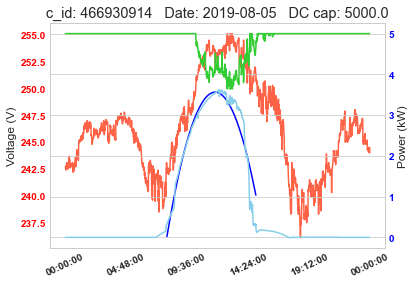

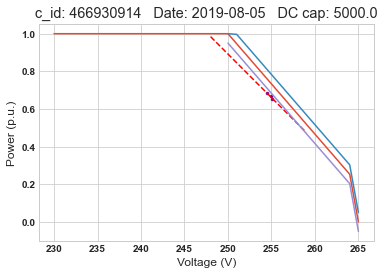

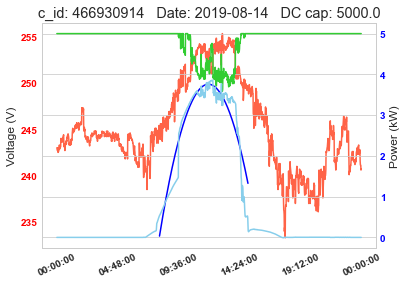

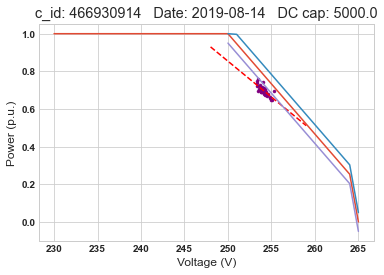

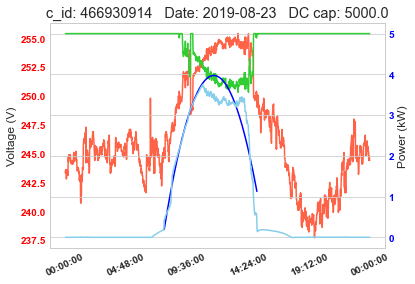

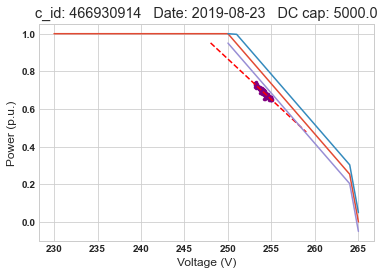

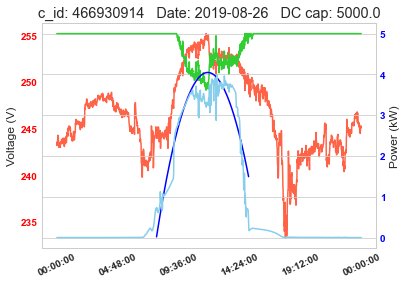

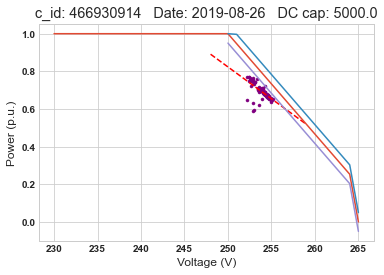

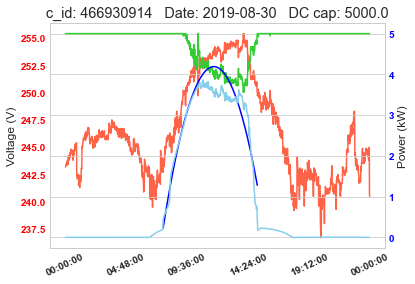

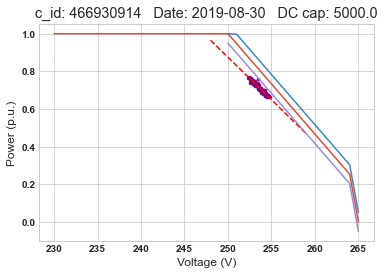

Length of sites determined to be assessable: 1

Total energy yields: 2022-08-26 08:53:06.374368

count: 1


/var/folders/94/k76q0vhs1lnchytv51v4bm100000gn/T/ipykernel_1949/453873406.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['utc_tstamp'] = c_data.apply(lambda row: remove_tstamp_ms(row['utc_tstamp']), axis=1)


In [23]:
file_path = '/Users/samhan/Downloads/data'
first_run("2019_08")

In [19]:
gc.collect()

1638

In [27]:
site_id_dict = {}
site_id_dict["NA"] = []
site_id_dict["VW"] = []
site_id_dict["NVW"] = []

print("\nVolt-Watt assessment of combined datapoints: " + str(datetime.now()) + "\n")
startTime = datetime.now()

Overall_volt_watt_assessment(overall_volt_watt_dict, 0.84, 0.035, 0.08)

print("\nFinished: " + str(datetime.now()) + ". Time taken: " + str(datetime.now() - startTime) + "\n")

print(overall_volt_watt_dict.keys())

#HERE
# complainceCountLimit = 150
# totalPointsCountLimit = 150
# upperAngleLimit = -0.03
# lowerAngleLimit = -0.06


Volt-Watt assessment of combined datapoints: 2022-08-26 09:06:48.001458



c_id: 466930914
Ran out of points at VWLimit 256
Best VWLimit: 246
Slope: -0.04053492461904629

!!! VOLT-WATT !!!

FOR4 buffer: 0.08


Volt-Watt sites: 1 = 100.0%
NON Volt-Watt sites: 0 = 0.0%
Not enough points to assess: 0
Total sites: 1

Finished: 2022-08-26 09:06:48.029546. Time taken: 0:00:00.027210

dict_keys([466930914])


In [32]:
# Second run through all the months: test for curtailment and show which sites have been added

overall_curtailment_dict = {}


print("\Started: " + str(datetime.now()) + "\n")

# for dateFile in dates:
def second_run(dateFile):
    
    overall_clear_sky_days_dict[dateFile] = []
    print("\nAnalysing Date: " + dateFile + "\n\n")

    ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

    clear_sky_days = []
    
#     overall_site_organiser = pers_overall_site_organiser
#     clear_sky_days = pers_clear_sky_days
#     site_id_list_235 = pers_site_id_list_235
#     site_id_list_255 = pers_site_id_list_255
#     cicuit_details = pers_cicuit_details
#     site_details = pers_site_details


    for date in separated_ghi_data.keys():
        ghi_df = separated_ghi_data[date]
        res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

        if res:
    #             print("Date: " + date + " is clear-sky.")
            clear_sky_days.append(date)
            overall_clear_sky_days_dict[dateFile].append(date)
    #             Display_ghi(date, ghi_df)


    if len(clear_sky_days) == 0:
        print("No clear sky days in month: " + dateFile)
        return
    #         continue
    else:
        print(str(len(clear_sky_days)) + " clear sky days detected.")
        print(clear_sky_days)

    telemetry_string = Get_telemetry_string(dateFile)

    print("\nLoading csv files: " + str(datetime.now()) + "\n")
    data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
    cicuit_details = pd.read_csv(file_path + "/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")


    print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
    clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)


    
    print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_lists = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list_235 = site_id_lists[235]
#     site_id_list_255 = site_id_lists[255]
    site_id_list_235 = [1641159822]

    
#     pers_site_id_list_235 = site_id_list_235
#     pers_site_id_list_255 = site_id_list_255
#     print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_list = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list = site_id_list[:10]
    #     print(site_id_list)

    print("\nOrganising sites: " + str(datetime.now()) + "\n")
    overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                            cicuit_details)
    
#     overall_site_organiser = pers_overall_site_organiser

    print("\nCurtailment for date: " + dateFile + "\n\n")

    keys = ["VW", "NVW"]
    
    

    print(str(len(site_id_dict["VW"])) + "/" + str(len(site_id_dict["VW"]) + len(site_id_dict["NVW"])) + " circuits identified as Volt-Watt enabled")
    print(str2(100*len(site_id_dict["VW"])/(len(site_id_dict["VW"]) + len(site_id_dict["NVW"]))) + "% of total sites.\n\n")

#     for key in keys:
#         print("Sites considered " + key)
    #         c_id_list = buffers_site_id_dict[b][key]
    c_id_list = site_id_dict["VW"]

    curtailment_count = []
    curtailment_percentage_count = []
    count = 1


    #HERE
#     for site_id in site_id_list:
    for site_id in site_id_list_235:
#     for site_id in pers_site_id_list_255:
#         if site_id not in overall_site_organiser.keys():
#             continue
        site = overall_site_organiser[site_id]


        for c_id in site.c_id_data.keys():

            if c_id in c_id_list:

                if c_id not in overall_curtailment_dict.keys():
                    overall_curtailment_dict[c_id] = {}
                    overall_curtailment_dict[c_id]["exp"] = 0
                    overall_curtailment_dict[c_id]["curt"] = 0

                print("\n\nSite no: " + str(count))
                count += 1
                circuit = site.c_id_data[c_id]

                total_curtailment = 0
                total_expected_energy = 0

                for date in clear_sky_days:


                    voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray, curtailment, expectedEnergy = Assess_curtailment_day(circuit.day_data[date], circuit.c_id, date, site.ac_cap_w)
                    if voltArray == None:
                        continue


                    print("c_id: " + str(c_id) + ", date: " + date)
                    print("Expected energy: " + str2(expectedEnergy) + "kWh")
                    print("Curtailment: " + str2(curtailment) + "kWh")
                    print("Percentage curtailed: " + str2(100*curtailment/(expectedEnergy)) + "%\n\n")

                    overall_curtailment_dict[c_id]["curt"] += curtailment
                    overall_curtailment_dict[c_id]["exp"] += expectedEnergy


print("\nFinished: " + str(datetime.now()) + "\n")
        

\Started: 2022-08-26 09:10:55.679251


Finished: 2022-08-26 09:10:55.680843



In [36]:
# QUANTIFY CURTAILMENT FUR TO V-WATT FOR SITES THAT HAVE ALREADY BEEN IDENTIFIED AS HAVING V-WATT ENABLED: FOR EACH DAY OF A CIRCUIT'S DATA
def Assess_curtailment_day(df, c_id, date, dc_cap_w):    

    if df is None:
        return None, None, None, None, None, None

    if len(df.index) == 0:
        return None, None, None, None, None, None
    
    if max(df.power) < 0.3:
        return None, None, None, None, None, None

    df = SliceEndOffDF(df)

    df = df.loc[df['power'] > 300]

    if len(df.index) < 20:
        return None, None, None, None, None, None


    powerArray, timeArray = FilterPowerData(df)

    powerArray, timeArray = FilterDataLimitedGradients(powerArray, timeArray)

    if powerArray is None or len(powerArray) < 20:
        return None, None, None, None, None, None

    polyfit = GetPolyfit(getDateTimeList(timeArray), powerArray, 2)

    filteredPowerArray, filteredTimeArray = FilterArray(polyfit(getDateTime(df)), getDateTime(df), 100000, 0)

    filteredPowerArray = Change_W_to_kW(filteredPowerArray)
    
    maxPower = max(filteredPowerArray)

    graphDF = df.loc[df['power'] > 0.1 * maxPower]
    powerData = graphDF.power.tolist()
    timeData = graphDF.ts.tolist()
    
    powerExpected = GetExpectedPower(timeData, polyfit)
    
    MeasuredEnergy = AreaUnderCurve(timeData, powerData)
    ExpectedEnergy = AreaUnderCurve(timeData, powerExpected)
    

    Curtailment = ExpectedEnergy - MeasuredEnergy
    if Curtailment < 0.01:
        Curtailment = 0
    
    maxCompliance = 0
    bestVWLimit = 248
    bestTotalPoints = 1
    complianceCount, voltArrayCompliance, timeArrayCompliance, absoluteWattArrayCompliance, relativeWattArrayCompliance, successfulRelativeWattArray, successfulVoltArray = DetermineCompliance(polyfit, df, dc_cap_w, 249)
    maxVoltWattTimeArray, maxVoltWattPowerArray = getMaxVoltWattCurve(dc_cap_w, df, 249)

    
    if len(voltArrayCompliance) > 0:
        return voltArrayCompliance, relativeWattArrayCompliance, filteredTimeArray, filteredPowerArray, Curtailment/1000, ExpectedEnergy/1000

    return None, None, None, None, None, None

# RETURN THE EXPECTED POWER DATA A SPECIFIC TIMESTAMP ACCORDING TO A GIVEN POLYFIT
def GetExpectedPower(timeData, polyfit):
    
    expectedPower = []
    
    for t in timeData:
        expectedPower.append(polyfit(getSingleDateTime(t)))
        
    return expectedPower

In [37]:
second_run("2019_08")


Analysing Date: 2019_08


5 clear sky days detected.
['2019-08-05', '2019-08-14', '2019-08-23', '2019-08-26', '2019-08-30']

Loading csv files: 2022-08-26 09:18:45.283271


Filtering clear sky data: 2022-08-26 09:19:28.555897



/var/folders/94/k76q0vhs1lnchytv51v4bm100000gn/T/ipykernel_1949/2423375697.py:123: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  filtered_df = filtered_df.append(tmp_df, ignore_index=True)



Finding over-voltage sites: 2022-08-26 09:19:44.047350


Organising sites: 2022-08-26 09:19:44.047528



/var/folders/94/k76q0vhs1lnchytv51v4bm100000gn/T/ipykernel_1949/2423375697.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)



Curtailment for date: 2019_08


1/1 circuits identified as Volt-Watt enabled
100.0% of total sites.




Site no: 1
c_id: 466930914, date: 2019-08-14
Expected energy: 18.83kWh
Curtailment: 0.33kWh
Percentage curtailed: 1.75%


c_id: 466930914, date: 2019-08-23
Expected energy: 20.86kWh
Curtailment: 0.73kWh
Percentage curtailed: 3.49%


c_id: 466930914, date: 2019-08-26
Expected energy: 21.14kWh
Curtailment: 0.86kWh
Percentage curtailed: 4.07%


c_id: 466930914, date: 2019-08-30
Expected energy: 22.48kWh
Curtailment: 1.02kWh
Percentage curtailed: 4.56%




In [38]:
# Second run through all the months: test for curtailment and show which sites have been added

#overall_curtailment_dict = {}

#print("\Started: " + str(datetime.now()) + "\n")

# for dateFile in dates:
def check_vvar_curtailment(date, data_site, ghi, is_clear_sky_day):
    
    overall_clear_sky_days_dict[dateFile] = []
    print("\nAnalysing Date: " + dateFile + "\n\n")

    ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
    timestamp_date_string = Get_timestamp_date_string(dateFile)
    separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

    clear_sky_days = []
    
#     overall_site_organiser = pers_overall_site_organiser
#     clear_sky_days = pers_clear_sky_days
#     site_id_list_235 = pers_site_id_list_235
#     site_id_list_255 = pers_site_id_list_255
#     cicuit_details = pers_cicuit_details
#     site_details = pers_site_details


    for date in separated_ghi_data.keys():
        ghi_df = separated_ghi_data[date]
        res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

        if res:
    #             print("Date: " + date + " is clear-sky.")
            clear_sky_days.append(date)
            overall_clear_sky_days_dict[dateFile].append(date)
    #             Display_ghi(date, ghi_df)


    if len(clear_sky_days) == 0:
        print("No clear sky days in month: " + dateFile)
        return
    #         continue
    else:
        print(str(len(clear_sky_days)) + " clear sky days detected.")
        print(clear_sky_days)

    telemetry_string = Get_telemetry_string(dateFile)

    print("\nLoading csv files: " + str(datetime.now()) + "\n")
    data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
    cicuit_details = pd.read_csv(file_path + "/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")


    print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
    clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)


    
    print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_lists = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list_235 = site_id_lists[235]
#     site_id_list_255 = site_id_lists[255]
    site_id_list_235 = [1641159822]

    
#     pers_site_id_list_235 = site_id_list_235
#     pers_site_id_list_255 = site_id_list_255
#     print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_list = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list = site_id_list[:10]
    #     print(site_id_list)

    print("\nOrganising sites: " + str(datetime.now()) + "\n")
    overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                            cicuit_details)
    
#     overall_site_organiser = pers_overall_site_organiser

    print("\nCurtailment for date: " + dateFile + "\n\n")

    keys = ["VW", "NVW"]
    
    

    print(str(len(site_id_dict["VW"])) + "/" + str(len(site_id_dict["VW"]) + len(site_id_dict["NVW"])) + " circuits identified as Volt-Watt enabled")
    print(str2(100*len(site_id_dict["VW"])/(len(site_id_dict["VW"]) + len(site_id_dict["NVW"]))) + "% of total sites.\n\n")

#     for key in keys:
#         print("Sites considered " + key)
    #         c_id_list = buffers_site_id_dict[b][key]
    c_id_list = site_id_dict["VW"]

    curtailment_count = []
    curtailment_percentage_count = []
    count = 1


    #HERE
#     for site_id in site_id_list:
    for site_id in site_id_list_235:
#     for site_id in pers_site_id_list_255:
#         if site_id not in overall_site_organiser.keys():
#             continue
        site = overall_site_organiser[site_id]


        for c_id in site.c_id_data.keys():

            if c_id in c_id_list:

                if c_id not in overall_curtailment_dict.keys():
                    overall_curtailment_dict[c_id] = {}
                    overall_curtailment_dict[c_id]["exp"] = 0
                    overall_curtailment_dict[c_id]["curt"] = 0

                print("\n\nSite no: " + str(count))
                count += 1
                circuit = site.c_id_data[c_id]

                total_curtailment = 0
                total_expected_energy = 0

                for date in clear_sky_days:


                    voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray, curtailment, expectedEnergy = Assess_curtailment_day(circuit.day_data[date], circuit.c_id, date, site.ac_cap_w)
                    if voltArray == None:
                        continue


                    print("c_id: " + str(c_id) + ", date: " + date)
                    print("Expected energy: " + str2(expectedEnergy) + "kWh")
                    print("Curtailment: " + str2(curtailment) + "kWh")
                    print("Percentage curtailed: " + str2(100*curtailment/(expectedEnergy)) + "%\n\n")

                    overall_curtailment_dict[c_id]["curt"] += curtailment
                    overall_curtailment_dict[c_id]["exp"] += expectedEnergy


print("\nFinished: " + str(datetime.now()) + "\n")=

SyntaxError: cannot assign to function call (635114833.py, line 140)

# MISCELLANEOUS

In [53]:
def input_general_files(file_path):
    circuit_details = pd.read_csv(file_path + r"/unsw_20190701_circuit_details.csv")
    site_details = pd.read_csv (file_path + r"/unsw_20190701_site_details.csv")
    site_details = site_details.merge(circuit_details, left_on = 'site_id', right_on = 'site_id')
    unique_cids = pd.read_csv(file_path + r"/UniqueCids.csv", index_col = 0)
    return site_details, unique_cids

def input_monthly_files(file_path, data_date_idx):
    data_path = file_path + r"/processed_unsw_" + data_date_idx + '_data_raw.csv'
    data = pd.read_csv(data_path, index_col = 1)

    # Convert timestamp to local Adelaide time
    data.index = pd.to_datetime(data.index) # convert index from object type to datetime
    Adelaide_local_time = pytz.timezone('Australia/Adelaide')
    data.index = data.index.tz_localize(pytz.utc).tz_convert(Adelaide_local_time) # convert utc to local adelaide time
    data.index.rename('Timestamp', inplace = True)

    # Load GHI data
    ghi_date_idx = data_date_idx[0:4] + '_' + data_date_idx[4:]
    ghi_path = file_path + r"/sl_023034_" + ghi_date_idx +'.txt'
    ghi = pd.read_csv (ghi_path) 

    ghi['timestamp'] = pd.to_datetime(pd.DataFrame ({'year' : ghi['Year Month Day Hours Minutes in YYYY'].values, 
                                                    'month' : ghi['MM'], 
                                                    'day' : ghi['DD'], 
                                                   'hour' : ghi['HH24'], 
                                                   'minute' : ghi['MI format in Local standard time']}))
    ghi.set_index('timestamp', inplace = True)
    # Deal with the space characters (ghi is in object/string form at the moment)
    ghi['Mean global irradiance (over 1 minute) in W/sq m'] = [float(ghi_t) if ghi_t.count(' ')<= 3 else np.nan for ghi_t in ghi['Mean global irradiance (over 1 minute) in W/sq m']]
    return data, ghi

In [46]:
def summarize_result_into_dataframe(c_id, date, energy_generated, is_clear_sky_day, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy):
    summary = pd.DataFrame({
        'c_id' : [c_id],
        'date' : [date],
        'energy generated (kWh)' : [energy_generated],
        'clear sky day': [is_clear_sky_day],
        'tripping response' : [tripping_response],
        'tripping curtailment (kWh)' : [tripping_curt_energy],
        'V-VAr response' : [vvar_response],
        'V-VAr curtailment (kWh)' : [vvar_curt_energy],
        'V-Watt response' : [vwatt_response],
        'V-Watt curtailment (kWh)' : [vwatt_curt_energy]
    })
    return summary

# MAIN PROGRAM

In [41]:
'''
site_details, unique_cids, data, ghi = input_general_files(file_path = r"C:\Users\samha\Documents\CANVAS\data")
for site in site_list:
    for month in month_list:
    data, ghi = input_monthly_file(file_path = r"C:\Users\samha\Documents\CANVAS\data")
    organized_site_file = site_organize(c_id_idx, site_details, data, unique_cids)
        for date in month:
            is_clear_sky_day = check_clear_sky(date)
            tripping_response, tripping_curtailed_energy = check_tripping_curtailment(c_id, date)
            vvar_response, vvar_curtailed_energy = check_vvar_curtailment(c_id, date)
            vwatt_response, vwatt_curtailed_energy = check_vwatt_curtailment(c_id, date)
summarize_result_into_dataframe()
show_summary()
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 76-77: truncated \UXXXXXXXX escape (1046678838.py, line 14)

# TRIAL FOR ONLY 1 SITE AND 1 DAY

In [54]:
#file_path = r"C:\Users\samha\Documents\CANVAS\data"
file_path = '/Users/samhan/Downloads/data'
site_details, unique_cids= input_general_files(file_path)

month = '201908'
c_id_idx = 466930914 #this is c_id having vwatt enabled.c_id: 466930914 / site_id 1641159822, date: 2019-08-14

data, ghi = input_monthly_files(file_path, month)
data_site, ac_cap, dc_cap, eff_system, inverter = site_organize(c_id_idx, site_details, data, unique_cids)

#date = '2019-07-21' #non clear sky day
#date = '2019-07-20' #clear sky day
date = '2019-08-14' #clear sky date with vwatt response

In [51]:
#file_path = r"C:\Users\samha\Documents\CANVAS\data"
file_path = '/Users/samhan/Downloads/data'
site_details, unique_cids= input_general_files(file_path)

month = '201907'
c_id_idx = 1018350709 #this is row 436 in the site id, and having the biggest vvar curtailment

data, ghi = input_monthly_files(file_path, month)
data_site, ac_cap, dc_cap, eff_system, inverter = site_organize(c_id_idx, site_details, data, unique_cids)

#date = '2019-07-21' #non clear sky day
date = '2019-07-20' #clear sky day

is_clear_sky_day = check_clear_sky_day(date)
energy_generated = check_energy_generated(data, date)
tripping_response, tripping_curt_energy = check_tripping_curtailment(is_clear_sky_day)
vvar_response, vvar_curt_energy = check_vvar_curtailment(c_id_idx, date, data_site, ghi, ac_cap, dc_cap, eff_system, is_clear_sky_day)
vwatt_response, vwatt_curt_energy = check_vwatt_curtailment(is_clear_sky_day)
summary = summarize_result_into_dataframe(c_id, date, energy_generated, is_clear_sky_day, tripping_response, tripping_curt_energy, vvar_response, vvar_curt_energy, vwatt_response, vwatt_curt_energy)


KeyboardInterrupt



In [524]:
summary

,c_id,date,energy generated (kWh),clear sky day,tripping response,tripping curtailment (kWh),V-VAr response,V-VAr curtailment (kWh),V-Watt response,V-Watt curtailment (kWh)
0,1018350709,2019-07-20,12.023056,True,Script will be available soon,Script will be available soon,Yes,0.817819,Script will be available soon,Script will be available soon


# MESSY BELOW

In [181]:
dateFile = '2019_08'
date = '2019-08-14' #clear sky date with vwatt response
c_id = 466930914
site_id = unique_cids[unique_cids['c_id'] == 466930914]['site_id'].iloc[0] #1641159822

In [183]:
site_id

1641159822

Length vMax > 235: 498
Length vMax > 236: 498
Length vMax > 237: 498
Length vMax > 238: 498
Length vMax > 239: 498
Length vMax > 240: 498
Length vMax > 241: 498
Length vMax > 242: 496
Length vMax > 243: 494
Length vMax > 244: 493
Length vMax > 245: 486
Length vMax > 246: 481
Length vMax > 247: 470
Length vMax > 248: 452
Length vMax > 249: 436
Length vMax > 250: 400
Length vMax > 251: 360
Length vMax > 252: 295
Length vMax > 253: 223
Length vMax > 254: 151
Length vMax > 255: 103

Analysing Date: 2019_08


1 clear sky days detected.
['2019-08-14']

LOADED DATA FILE: 2022-08-26 12:31:58.742307


Filtering clear sky data: 2022-08-26 12:31:58.743354


Finding over-voltage sites: 2022-08-26 12:32:04.064318


Organising sites: 2022-08-26 12:32:04.066284


Adding Volt-Watt data: 2022-08-26 12:32:04.239688

count: 0
1641159822


/var/folders/94/k76q0vhs1lnchytv51v4bm100000gn/T/ipykernel_1949/2423375697.py:170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inverter_telemetry['ts'] = inverter_telemetry.apply(lambda row: Convert_to_SA_time(row['utc_tstamp']), axis=1)


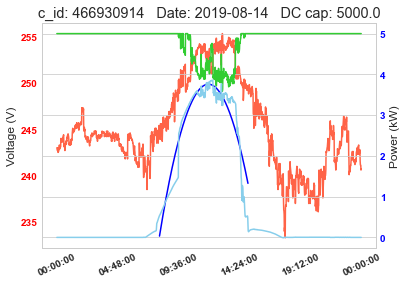

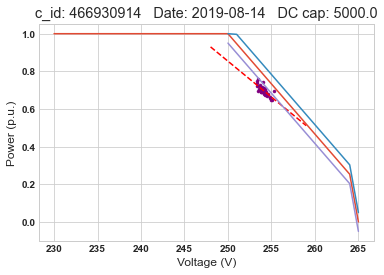

Length of sites determined to be assessable: 1

Total energy yields: 2022-08-26 12:32:05.166494

count: 1


/var/folders/94/k76q0vhs1lnchytv51v4bm100000gn/T/ipykernel_1949/2423375697.py:472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_data['utc_tstamp'] = c_data.apply(lambda row: remove_tstamp_ms(row['utc_tstamp']), axis=1)


In [186]:
total_energy_yield_dict = {}
site_id_lists = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#ABOVE SHOULD BE PLACED OUTSIDE OF DATE LOOP, INSIDE THE MONTH LOOP

plt.interactive(False)
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 320)
pd.set_option('display.max_columns', 10)


site_id_list_235 = None
#dates = ["2019_07", "2019_08", "2019_09", "2019_10", "2019_11", "2019_12", "2020_01", "2020_02", "2020_03", "2020_04"]
dates = ["2019_08"]

overall_volt_watt_dict = {}

overall_clear_sky_days_dict = {}

# FIRST PASS AGGREGATIONG OF DATA FOR EACH SITE
overall_clear_sky_days_dict[dateFile] = []
print("\nAnalysing Date: " + dateFile + "\n\n")

ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
timestamp_date_string = Get_timestamp_date_string(dateFile)
separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

clear_sky_days = []


#for date in separated_ghi_data.keys():
ghi_df = separated_ghi_data[date]
res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

if res:
    clear_sky_days.append(date)
    overall_clear_sky_days_dict[dateFile].append(date)


if len(clear_sky_days) == 0:
    print("No clear sky days in month: " + dateFile)
    vwatt_response = 'Inconclusive because not a clear sky day'
else:
    print(str(len(clear_sky_days)) + " clear sky days detected.")
    print(clear_sky_days)

telemetry_string = Get_telemetry_string(dateFile)

pers_clear_sky_days = clear_sky_days

data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
cicuit_details = pd.read_csv(file_path +"/unsw_20190701_circuit_details.csv")
site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")
print("\nLOADED DATA FILE: " + str(datetime.now()) + "\n")

print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)

pers_cicuit_details = cicuit_details
pers_site_details = site_details

print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
if site_id in site_id_lists[235]:
    site_id_list_235 = [1641159822]
else:
    site_id_list_235 = []

pers_site_id_list_235 = site_id_list_235
#pers_site_id_list_255 = site_id_list_255

print("\nOrganising sites: " + str(datetime.now()) + "\n")
overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                        cicuit_details)

#     print(overall_site_organiser)
#     print(type(overall_site_organiser))
#     print(overall_site_organiser.keys())
#     print(overall_site_organiser[1641159822])

pers_overall_site_organiser = overall_site_organiser


print("\nAdding Volt-Watt data: " + str(datetime.now()) + "\n")
count = 0
for site_id in site_id_list_235:

    print("count: " + str(count))
    print(site_id)
    count += 1
    Assess_Volt_Watt_behaviour_site(overall_site_organiser[site_id], clear_sky_days, overall_volt_watt_dict)

print("\nTotal energy yields: " + str(datetime.now()) + "\n")
determine_total_energy_yields(dateFile, data, overall_site_organiser)

In [ ]:
site_id_dict = {}
site_id_dict["NA"] = []
site_id_dict["VW"] = []
site_id_dict["NVW"] = []

print("\nVolt-Watt assessment of combined datapoints: " + str(datetime.now()) + "\n")
startTime = datetime.now()

Overall_volt_watt_assessment(overall_volt_watt_dict, 0.84, 0.035, 0.08)

print("\nFinished: " + str(datetime.now()) + ". Time taken: " + str(datetime.now() - startTime) + "\n")

print(overall_volt_watt_dict.keys())

#HERE
# complainceCountLimit = 150
# totalPointsCountLimit = 150
# upperAngleLimit = -0.03
# lowerAngleLimit = -0.06

if c_id in site_id_dict['NA']:
    vwatt_response = 'Inconclusive'
elif c_id in site_id_dict['VW']:
    vwatt_response = 'Yes'
else:
    vwatt_response = 'None'

In [180]:
site_id_dict

{'NA': [466930914], 'VW': [], 'NVW': []}

In [179]:
site_id_list_235

[1641159822]

In [ ]:
# Second run through all the months: test for curtailment and show which sites have been added

overall_curtailment_dict = {}


print("\Started: " + str(datetime.now()) + "\n")

# for dateFile in dates:
    
overall_clear_sky_days_dict[dateFile] = []
print("\nAnalysing Date: " + dateFile + "\n\n")

ghi = pd.read_csv(file_path + "/sl_023034_" + dateFile + ".txt")
timestamp_date_string = Get_timestamp_date_string(dateFile)
separated_ghi_data = Separate_ghi_data(timestamp_date_string, ghi)

clear_sky_days = []

#     overall_site_organiser = pers_overall_site_organiser
#     clear_sky_days = pers_clear_sky_days
#     site_id_list_235 = pers_site_id_list_235
#     site_id_list_255 = pers_site_id_list_255
#     cicuit_details = pers_cicuit_details
#     site_details = pers_site_details

#for date in separated_ghi_data.keys():
ghi_df = separated_ghi_data[date]
res, average_delta_y = Detect_clear_sky_day(ghi_df, 530)

if res:
#             print("Date: " + date + " is clear-sky.")
    clear_sky_days.append(date)
    overall_clear_sky_days_dict[dateFile].append(date)
#             Display_ghi(date, ghi_df)

if len(clear_sky_days) == 0:
    print("No clear sky days in month: " + dateFile)
#         continue
else:
    print(str(len(clear_sky_days)) + " clear sky days detected.")
    print(clear_sky_days)

telemetry_string = Get_telemetry_string(dateFile)

print("\nLoading csv files: " + str(datetime.now()) + "\n")
data = pd.read_csv(file_path + "/processed_unsw_" + telemetry_string + "_data_raw.csv")
cicuit_details = pd.read_csv(file_path + "/unsw_20190701_circuit_details.csv")
site_details = pd.read_csv(file_path + "/unsw_20190701_site_details.csv")


print("\nFiltering clear sky data: " + str(datetime.now()) + "\n")
clear_sky_data = Filter_data_clear_sky_days(data, clear_sky_days)

print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_lists = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list_235 = site_id_lists[235]
#     site_id_list_255 = site_id_lists[255]
# site_id_list_235 = [1641159822]


#     pers_site_id_list_235 = site_id_list_235
#     pers_site_id_list_255 = site_id_list_255
#     print("\nFinding over-voltage sites: " + str(datetime.now()) + "\n")
#     site_id_list = Find_over_voltage_sites(255, clear_sky_data, cicuit_details)
#     site_id_list = site_id_list[:10]
#     print(site_id_list)

print("\nOrganising sites: " + str(datetime.now()) + "\n")
overall_site_organiser = Organise_sites(clear_sky_days, site_id_list_235, timestamp_date_string, clear_sky_data, site_details,
                                        cicuit_details)

#     overall_site_organiser = pers_overall_site_organiser

print("\nCurtailment for date: " + dateFile + "\n\n")

keys = ["VW", "NVW"]



print(str(len(site_id_dict["VW"])) + "/" + str(len(site_id_dict["VW"]) + len(site_id_dict["NVW"])) + " circuits identified as Volt-Watt enabled")
print(str2(100*len(site_id_dict["VW"])/(len(site_id_dict["VW"]) + len(site_id_dict["NVW"]))) + "% of total sites.\n\n")

#     for key in keys:
#         print("Sites considered " + key)
#         c_id_list = buffers_site_id_dict[b][key]
c_id_list = site_id_dict["VW"]

curtailment_count = []
curtailment_percentage_count = []
count = 1

#HERE
#     for site_id in site_id_list:
#for site_id in site_id_list_235:
#     for site_id in pers_site_id_list_255:
#         if site_id not in overall_site_organiser.keys():
#             continue
site = overall_site_organiser[site_id]


#for c_id in site.c_id_data.keys():

if c_id in c_id_list:

    if c_id not in overall_curtailment_dict.keys():
        overall_curtailment_dict[c_id] = {}
        overall_curtailment_dict[c_id]["exp"] = 0
        overall_curtailment_dict[c_id]["curt"] = 0

    print("\n\nSite no: " + str(count))
    count += 1
    circuit = site.c_id_data[c_id]

    total_curtailment = 0
    total_expected_energy = 0

    for date in clear_sky_days:


        voltArray, relativeWattArray, filteredTimeArray, filteredPowerArray, curtailment, expectedEnergy = Assess_curtailment_day(circuit.day_data[date], circuit.c_id, date, site.ac_cap_w)
        if voltArray == None:
            continue


        print("c_id: " + str(c_id) + ", date: " + date)
        print("Expected energy: " + str2(expectedEnergy) + "kWh")
        print("Curtailment: " + str2(curtailment) + "kWh")
        print("Percentage curtailed: " + str2(100*curtailment/(expectedEnergy)) + "%\n\n")

        overall_curtailment_dict[c_id]["curt"] += curtailment
        overall_curtailment_dict[c_id]["exp"] += expectedEnergy


print("\nFinished: " + str(datetime.now()) + "\n")
